# Predicting relative permeability

This is an example of calculating relative permeability in OpenPNM.

In [1]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

### Create network and phases

First, we create a network and assign phases and properties in a similar way that we used to do for the other examples. Note that `op.models.collections.phase` is added to assign fluid properties such as viscosity, surface tension, etc, and `op.models.collections.physics` is added to assign pore-scale models such as entry pressure, conduit conductance. Surface tension info will be used in Invasion percolation in the next step. Here, we assumed a user-defined value for air surface tension and contact angle, as they are not included in `collections.phase.air`.

In [2]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:47,867    
------------------------------------------------------------


### Apply invasion percolation

The next step is to apply an invasion percolation algorithm to obtain the invasion sequence. Asumming a drainage process, the air(invading/non-wetting phase) will be invading the medium. The IP algorithm can be impplemented through a user-defined inlet face. Here, we use the left surface pores in the x direction. By updating the air phase, the invasion sequence can then be found using the phase occupancy which is a property of the phase.

In [3]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('left')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

### Occupancy and permeability functions

To update the occupancy of phases at each saturation point, we created a costum function:

In [4]:
def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation or ordinary percolation.
        Parameters
        ----------
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

As relative permeability is the ratio of effective over absolute permeability, given the same boundary condition and viscosity, the geometrical parameters in $K_{rphase}$ will cancel out. The remaining fraction includes flow rates as follows:

$K_{rphase}=\frac {K_{ephase}}{K_{abs}}=\frac {Q_{e-phase}}{Q_{abs-phase}}$

Where $Q_{ephase}$ is the inlet flow rate of the phase (water/air) for a Stokes flow algorithm with `multiphase conduit_conductance` assigned as conduit hydraulic conductance model to account for the existence of the other phase. Whereas $Q_{abs}$ is the inlet flow rate of the phase (water/air) for a Stokes flow algorithm with `generic_hydraulic_conductance` assigned as hydraulic conductance model for a single phase flow.


Note that $K_{abs}$ is a property of the porous material, not the fluid. However, here to cancel out viscosity in the $K_{rphase}$ fraction, the same phase must be used to calculate $Q_{abs-phase}$. Therefore, naming `abs-phase` was used here to indicate the flow rate from a single phase flow algorithm for the same phase that relative permeability is being calculated.
Therefore, we only need to find the rate values for calcuating the relative permeability. 


We define a function `Rate_calc`, which simulates a stokes flow given the hydraulic conductance keyword and returns the rate of inlet fluid flow. 

In [5]:
def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

In this example we are focusing on finding the relativep permeabilities in x direction. A similar procedure can be applied on y and z directions. Let's define inlet and outlet pores:

In [6]:
flow_in = pn.pores('left')
flow_out = pn.pores('right')

### Define multiphase conductance

Assigning multiphase conductance models to the phases. The multiphase conduit conductance accounts for the presence of the other phase in effective permeability calculations. For more details, plesase see the model's code in OpenPNM package.

In [7]:
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

### Calculate relative permeabilities

Now that we have defined the required models and functions, we can find the relative permeability of phases over a range of saturation. We selected 10 saturation points. A higher value can be used to obtain a better approximation of the curve.

In [8]:
Snwp_num=10
flow_in = pn.pores('left')
flow_out = pn.pores('right')
max_seq = np.max([np.max(ip['pore.invasion_sequence']),
          np.max(ip['throat.invasion_sequence'])])
start = max_seq//Snwp_num
stop = max_seq
step = max_seq//Snwp_num
Snwparr = []
relperm_nwp = []
relperm_wp = []

In [9]:
for i in range(start, stop, step):
    air.regenerate_models();
    water.regenerate_models();
    sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
    Snwparr.append(sat)
    Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
    relperm_wp.append(Rate_ewp/Rate_abs_wp)

------------------------------------------------------------
  - ERROR  : throat.conduit_hydraulic_conductance was not run since the following property is missing:
             'throat.occupancy' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:51,602    
------------------------------------------------------------
------------------------------------------------------------
  - ERROR  : throat.conduit_hydraulic_conductance was not run since the following property is missing:
             'throat.occupancy' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:51,651    
------------------------------------------------------------
------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:51,654    
---------------------------

------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:51,980    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:52,312    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:52,581    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:52,944    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:53,337    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:53,832    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:54,048    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:54,380    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:54,580    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:54,811    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:55,246    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:55,557    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:55,781    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:56,179    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:56,383    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:56,592    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:56,900    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:57,172    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:57,365    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:57,654    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:57,823    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:58,024    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:58,343    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:58,488    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:58,678    
------------------------------------------------------------


------------------------------------------------------------
  - ERROR  : throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-01 16:10:58,952    
------------------------------------------------------------


Let's plot the relative permeability curves:

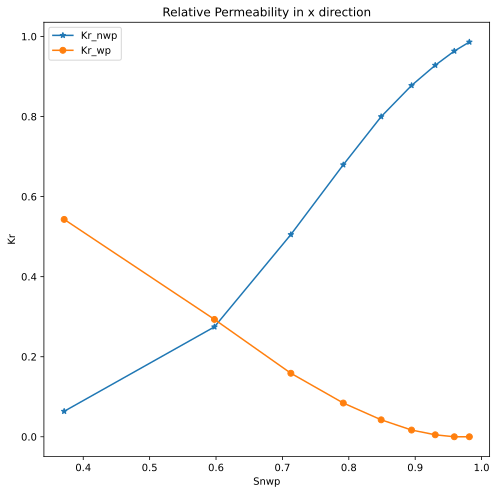

In [10]:
plt.figure(figsize=[8,8])
plt.plot(Snwparr, relperm_nwp, '*-', label='Kr_nwp')
plt.plot(Snwparr, relperm_wp, 'o-', label='Kr_wp')
plt.xlabel('Snwp')
plt.ylabel('Kr')
plt.title('Relative Permeability in x direction')
plt.legend()